# Code Assignment — Residual ACF/PACF + Prophet (Builds on Last COVID-19 TS Assignment)

**Dataset (local CSV):** NYC COVID-19 daily counts (static export)  
**Target:** `case_count`

## Instructor Guidance (Documentation + Pseudocode)

**Docs**
- statsmodels ARIMA: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html  
- ADF (adfuller): https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html  
- ACF/PACF: https://www.statsmodels.org/stable/graphics.html#autocorrelation-plots  
- Prophet: https://facebook.github.io/prophet/docs/quick_start.html  
- RMSE (sklearn MSE): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html  

**Pseudocode Workflow**
1) **Load CSV** → normalize columns; parse date.  
2) **Build daily time series** using `date_of_interest` as index; target = `case_count`; `asfreq('D')`; `interpolate('linear')`.  
3) **Chronological split (80/20)** → `train = first 80%`, `test = last 20%`.  
4) **Stationarity check (given)** → ADF on **differenced train**.  
5) **Baseline forecast (given)** → last train value for all test steps; compute **RMSE**.  
6) **ARIMA(1,1,1) (given)** → fit on **train**, forecast `len(test)`, compute **RMSE**; save **residuals**.  
7) **YOU DO:** Plot **ACF** and **PACF** of ARIMA **residuals**; comment on significant lags vs. bands.  
8) **YOU DO:** Fit **Prophet** on **train**, forecast over **test** horizon, compute **RMSE**, and plot vs. actuals.  
9) **YOU DO:** Plot residuals over time and write a 2–3 sentence interpretation.  
10) **Compare RMSEs** (Baseline vs. ARIMA vs. Prophet) and reflect on which generalizes best.

> **Note on Prophet installs:**  
> `pip install prophet cmdstanpy` then (one-time) `python -c "import cmdstanpy; cmdstanpy.install_cmdstan()"`.


In [18]:
# STEP 0 — Imports  |  RUN THIS CELL WITHOUT CHANGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# For YOUR ACF/PACF step later
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prophet
from prophet import Prophet

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


### Step 1 — Load CSV and preview 


In [2]:
# RUN THIS CELL WITHOUT CHANGES Except changing filepath
DATA_PATH = '/Users/Marcy_Student/Desktop/Marcy-Modules/marcy-git/DA2025_Lectures/Mod6/data/covid_copy.csv'   # <-- update path

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.lower().str.strip()

date_col = "date_of_interest"
target_col = "case_count"

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col)

# Coerce target to numeric (handles '1,141' strings)
df[target_col] = pd.to_numeric(df[target_col].astype(str).str.replace(",", "", regex=False), errors="coerce")

print(df.head())
print("Range:", df[date_col].min(), "→", df[date_col].max())


  date_of_interest  case_count probable_case_count hospitalized_count  \
0       2020-02-29           1                   0                  1   
1       2020-03-01           0                   0                  1   
2       2020-03-02           0                   0                  2   
3       2020-03-03           1                   0                  7   
4       2020-03-04           5                   0                  2   

   death_count case_count_7day_avg all_case_count_7day_avg  \
0            0                   0                       0   
1            0                   0                       0   
2            0                   0                       0   
3            0                   0                       0   
4            0                   0                       0   

  hosp_count_7day_avg  death_count_7day_avg bx_case_count  ... si_case_count  \
0                   0                     0             0  ...             0   
1                   0       

### Step 2 — Build daily time series and fill small gaps
- Set date index, `asfreq('D')`, `interpolate('linear')`.

In [3]:
# RUN THIS CELL WITHOUT CHANGES
s = df.set_index(date_col)[target_col].asfreq("D")
s = s.astype("float64").interpolate("linear")

print("Series:", target_col, "| length:", len(s), "| range:", s.index.min().date(), "→", s.index.max().date())
s.head()


Series: case_count | length: 2054 | range: 2020-02-29 → 2025-10-13


date_of_interest
2020-02-29   1.000
2020-03-01   0.000
2020-03-02   0.000
2020-03-03   1.000
2020-03-04   5.000
Freq: D, Name: case_count, dtype: float64

### Step 3 — Chronological split (80/20)
- First 80% → **train**; last 20% → **test**.


Train: 2020-02-29 → 2024-08-28 | n = 1643
Test : 2024-08-29 → 2025-10-13 | n = 411


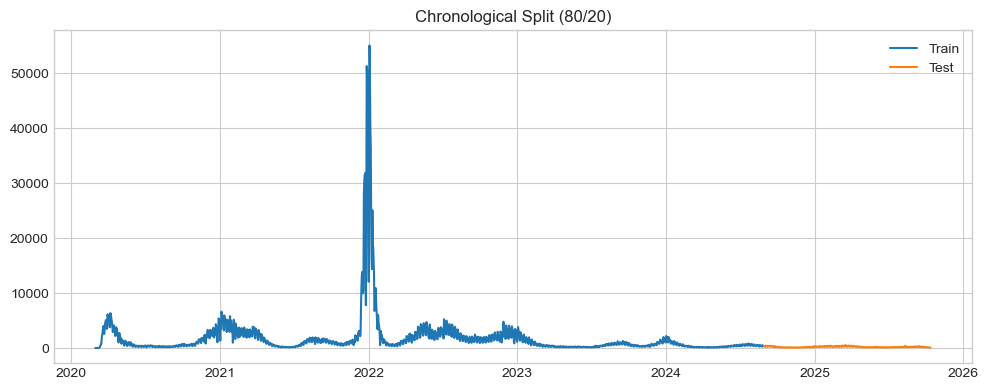

In [4]:
# RUN THIS CELL WITHOUT CHANGES
split_idx = int(len(s) * 0.80)
train = s.iloc[:split_idx]
test  = s.iloc[split_idx:]

print("Train:", train.index.min().date(), "→", train.index.max().date(), "| n =", len(train))
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  "| n =", len(test))

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test,  label="Test", color="#ff7f0e")
plt.title("Chronological Split (80/20)")
plt.legend(); plt.tight_layout(); plt.show()


### Step 4 — ADF on **differenced train** (stationarity check)
- If p < 0.05, **d=1** is reasonable in ARIMA.


In [5]:
# RUN THIS CELL WITHOUT CHANGES
diff_train = train.diff().dropna()
adf_stat, adf_p, _, _, crit, _ = adfuller(diff_train)
print(f"[ADF on differenced TRAIN] stat={adf_stat:.3f}, p={adf_p:.4f}")
for k, v in crit.items():
    print(f"  critical {k}: {v:.3f}")


[ADF on differenced TRAIN] stat=-9.677, p=0.0000
  critical 1%: -3.434
  critical 5%: -2.863
  critical 10%: -2.568


### Step 5 — Baseline (naïve/shift) forecast + RMSE
- Forecast = last train value repeated.

Baseline RMSE: 215.047


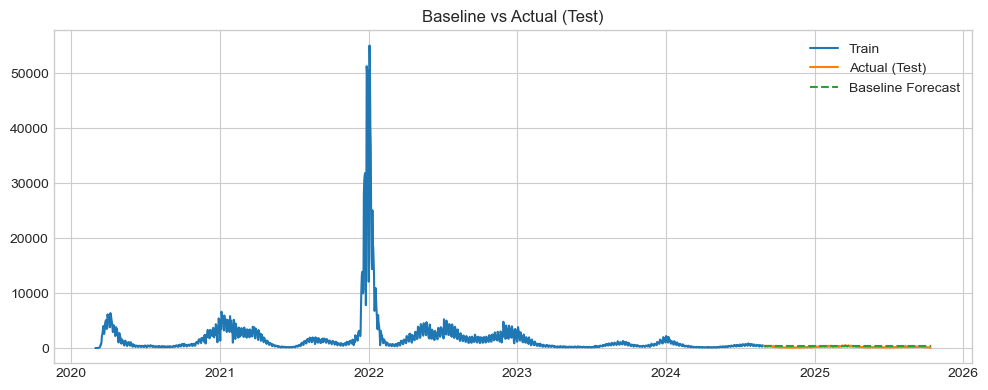

In [11]:
# RUN THIS CELL WITHOUT CHANGES
baseline_pred = pd.Series(train.iloc[-1], index=test.index)
rmse_baseline = np.sqrt(mean_squared_error(test, baseline_pred))
print(f"Baseline RMSE: {rmse_baseline:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(baseline_pred, label="Baseline Forecast", color="#2ca02c", ls="--")
plt.title("Baseline vs Actual (Test)")
plt.legend(); plt.tight_layout(); plt.show()


### Step 6 — ARIMA(1,1,1) fit → forecast → RMSE
- Fit on **train** only; forecast length = `len(test)`.

ARIMA(1,1,1) RMSE: 261.128


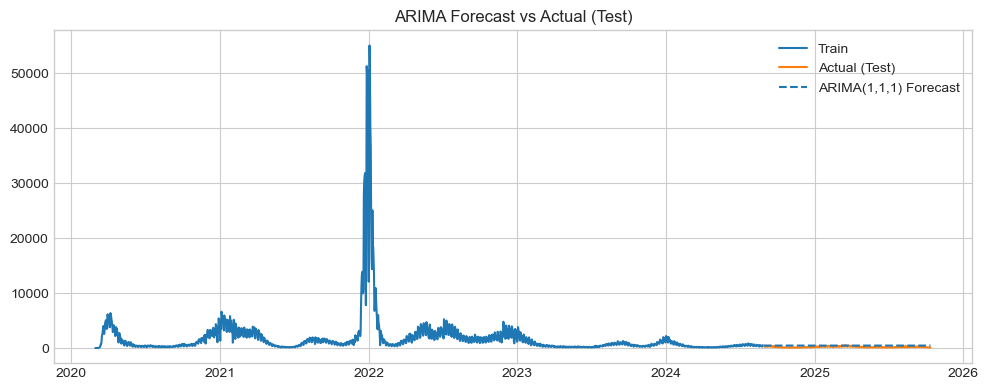

In [12]:
# RUN THIS CELL WITHOUT CHANGES
arima_model = ARIMA(train, order=(1, 1, 1)).fit()
pred_arima = arima_model.forecast(steps=len(test))
rmse_arima = np.sqrt(mean_squared_error(test, pred_arima))
residuals = arima_model.resid  # save for diagnostics
print(f"ARIMA(1,1,1) RMSE: {rmse_arima:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(pred_arima, label="ARIMA(1,1,1) Forecast", color="#1f77b4", ls="--")
plt.title("ARIMA Forecast vs Actual (Test)")
plt.legend(); plt.tight_layout(); plt.show()


### Step 7 — YOU DO: Residual Diagnostics with ACF & PACF
- Plot **ACF** and **PACF** of `residuals` (from ARIMA).  
- Interpretation cues:
  - **Good:** bars mostly within bands → residuals ≈ white noise.  
  - **Spike at lag 7 or 12:** missed weekly/monthly seasonality → consider SARIMA.  
  - **PACF spike at lag p:** consider higher AR(p).  
  - **ACF spike at lag q:** consider higher MA(q).


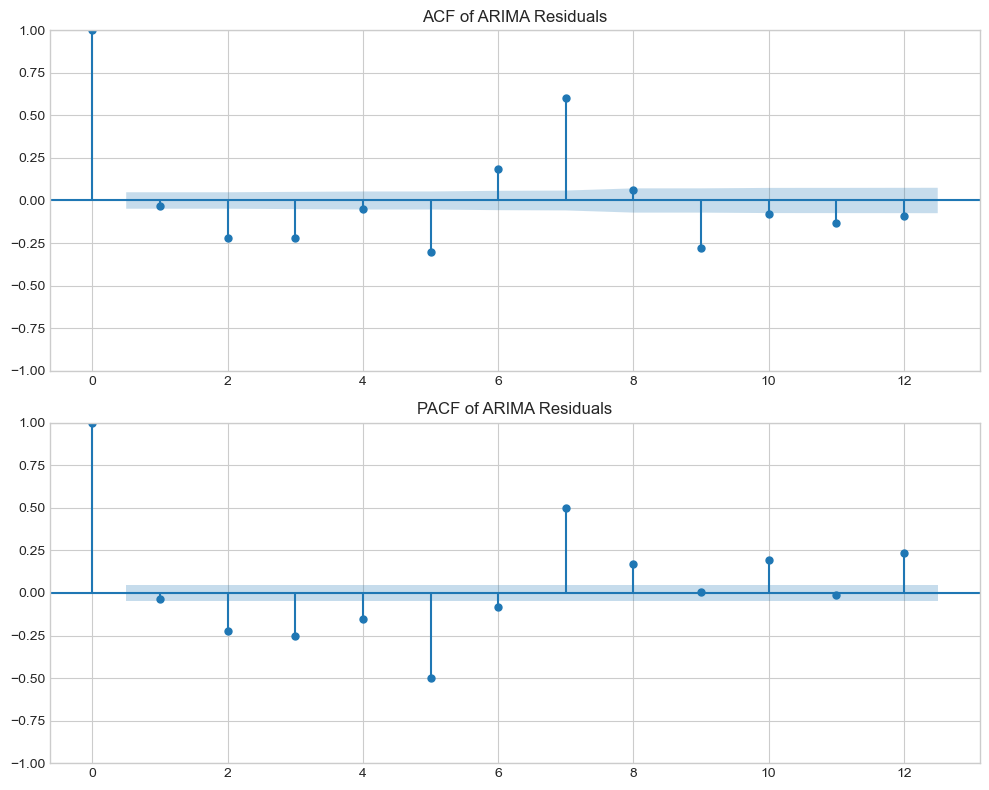

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(residuals, ax=ax[0], lags=12)
ax[0].set_title("ACF of ARIMA Residuals")

plot_pacf(residuals, ax=ax[1], lags=12, method="ywm")
ax[1].set_title("PACF of ARIMA Residuals")

plt.tight_layout()
plt.show()

### Step 8 — YOU DO: Prophet model → forecast → RMSE
- Fit **Prophet** on **train** (rename columns to `ds` and `y`).  
- Forecast over the **test** horizon (same dates as `test.index`).  
- Compute **RMSE** and plot vs. actual.  
- If installation errors occur, install:
  - `pip install prophet cmdstanpy`
  - one-time: `python -c "import cmdstanpy; cmdstanpy.install_cmdstan()"`


14:01:52 - cmdstanpy - INFO - Chain [1] start processing
14:01:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


             ds      yhat  yhat_lower  yhat_upper
1650 2025-03-31 1,014.974  -3,310.881   5,470.234
1651 2025-04-30   263.046  -4,109.445   4,609.522
1652 2025-05-31  -958.824  -5,580.262   3,305.380
1653 2025-06-30   366.783  -4,789.515   4,439.231
1654 2025-07-31   287.477  -4,514.587   5,101.405


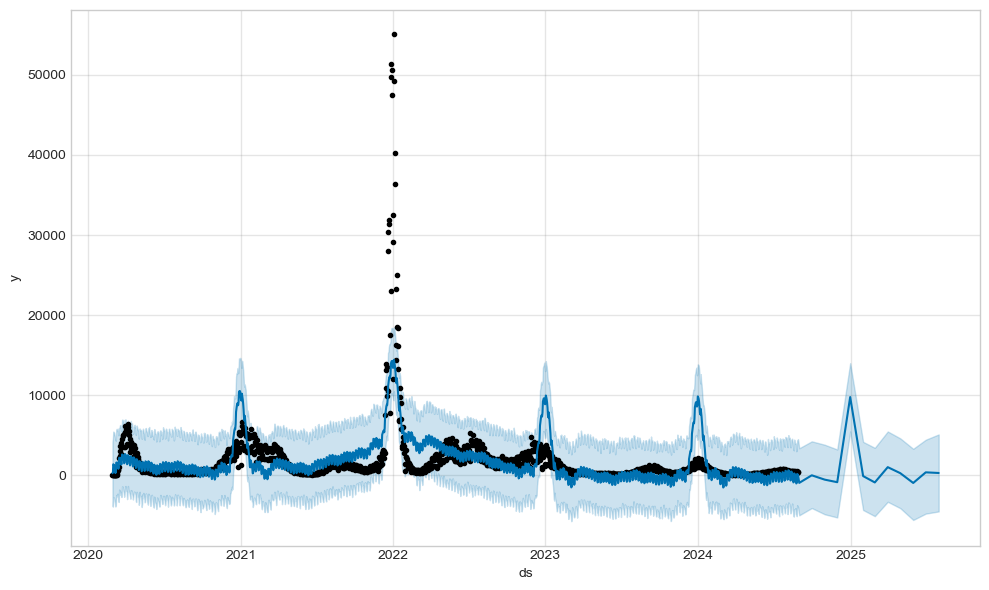

In [44]:
# renaming our columns to input for Prophet
ts_prophet = s.reset_index()
ts_prophet.columns = ['ds', 'y']

#resplitting
p_split_idx = int(len(ts_prophet) * 0.80)
p_train = ts_prophet.iloc[:p_split_idx]
p_test  = ts_prophet.iloc[p_split_idx:]

# Our Prophet Model
prophet_model = Prophet().fit(p_train)

# Creating future df
future = prophet_model.make_future_dataframe(periods=12, freq='M')

# forecasting
forecast = prophet_model.predict(future)

# visualizing
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
fig1 = prophet_model.plot(forecast)
plt.show()

### Step 9 — YOU DO: Residuals over time + short interpretation
- Plot `residuals` vs. time; aim for random scatter around 0.  
- Write 2–3 sentences: Do residuals look like white noise? If not, what would you try (adjust p/q, SARIMA)?


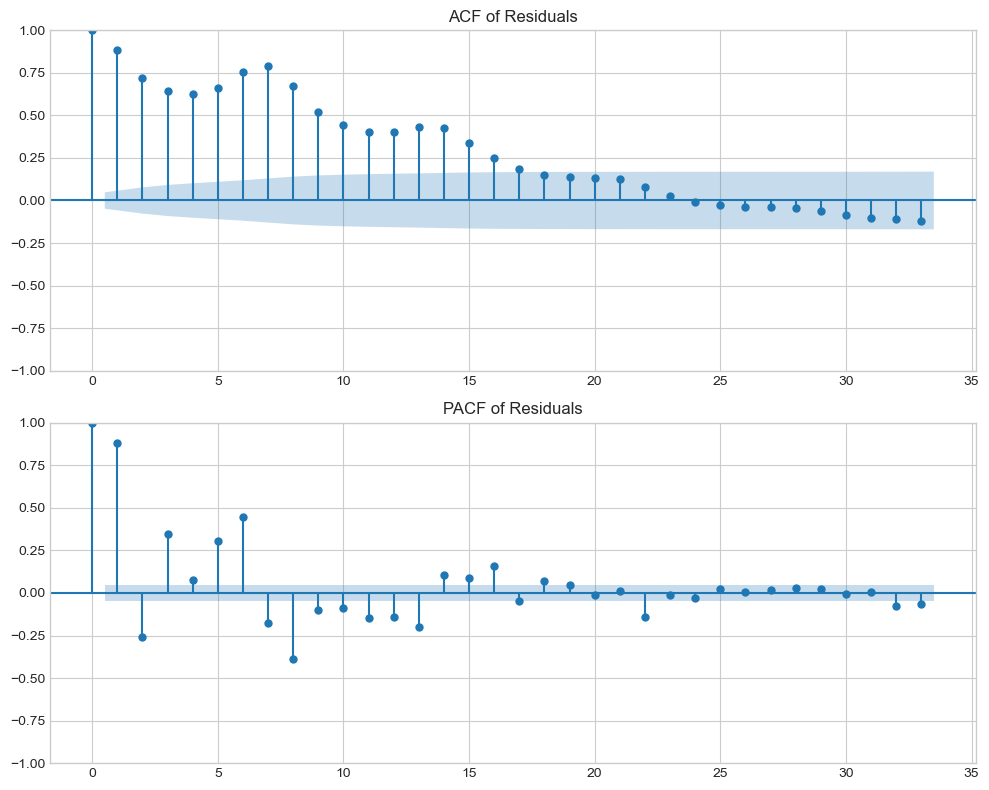

In [72]:
# prophet residuals
p_resid = pd.merge(left=forecast[['ds', 'yhat']], right=ts_prophet, on='ds', how='left')
p_resid['residual'] = p_resid['y'] - p_resid['yhat']

# plotting our residuals baby
fig2, ax2 = plt.subplots(2, 1, figsize=(10, 8))

# ACF
plot_acf(p_resid['residual'], ax=ax2[0])
ax2[0].set_title('ACF of Residuals')

# PACF
plot_pacf(p_resid['residual'], ax=ax2[1])
ax2[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

### Step 10 — YOU DO:  Compare RMSEs and declare a winner
- Create a small table with Baseline, ARIMA, Prophet RMSEs.  
- Which model generalized best? By how much vs. baseline?


In [79]:
# calculating RMSE for Prophet Model
rmse_prophet = np.sqrt(mean_squared_error(p_resid['y'], p_resid['yhat']))

rmse_table = pd.DataFrame({
    'Model': ['Baseline', 'ARIMA', 'Prophet'],
    'RMSE': [rmse_baseline, rmse_arima, rmse_prophet]
})

display(rmse_table)


,Model,RMSE
0,Baseline,215.047
1,ARIMA,261.128
2,Prophet,"3,243.989"


## We Share — Reflection
- Did ACF/PACF suggest remaining structure (specific lags)? What change would you try first?  
- Which model won on **RMSE**? Any business intuition why (trend shifts, seasonality, holiday effects)?  
- If this went to production, what **guardrails** (intervals, fallback baseline, anomaly flags) would you put in place?
